# Image de-blurring project

We'll learn about ways to try to restore blurry images if you know how they were blurred. We will see that many image blurring and deblurring tasks are related to simple matrix-vector products. Numerical issues deeply connected to the blurring process will cause trouble for us that we will learn to work around...

## Using Octave and Jupyter

We're switching from MATLAB to the free and open-source **Octave** program (also called 'GNU/Octave') running from the (also free, open) **Jupyter notebook** interface (what you see in front of you). Octave is very similar to MATLAB.

With one small change below, all of the codewill also run in MATLAB if you download the 'gblur.m' file on the left, so feel free to try things out in the old online MATLAB interface if you're more comfortable with it.

Try to play around in this interface, we will try to use it for most of the rest of the course. Jupyter is a notebook interface popular with *many* languages and computing environments, including Python, Julia, R, Octave, and many others. It is extraordinarily popular with machine learning folks. So it's likely that you will encounter this software sometime in your career going forward.

You can edit cells in the Jupyter interface by clicking and typing. To re-compute any cell press SHIFT + ENTER, or press the play button at the top of the window. Double-clicking on any notebook cell shows many options.

## Loading an image into Octave (or MATLAB)

The version of Octave we're using in this web interface has a bug in the MATLAB-equivalent **imread** function. 
Also, this notebook uses a free hosting service called "Binder" that can be *very* slow sometimes. I am looking in to ways to improve that. Otherwise, it works OK. I wrote a special work-around function for this project to load images called **readimage** that you can use instead. It works very similarly to the MATLAB **imread** function.

Let's get started and load a test image from the internet...

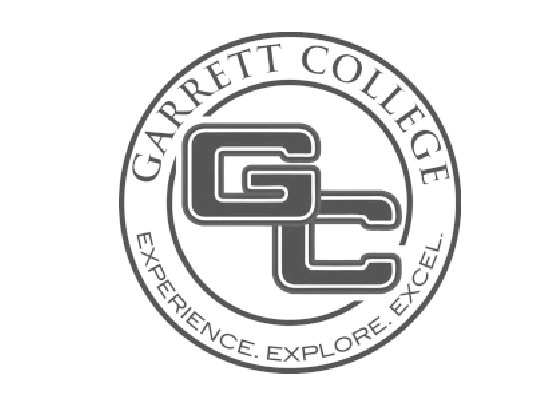

In [1]:
X = readimage("https://raw.githubusercontent.com/bwlewis/enr230-image-deblurring/main/gc.jpeg");
imshow(X);

We loaded the image into a matrix called X. You can try loading other images by replacing the link above, but for the rest of this project to work they will need to be square -- that is the same number of rows as columns. If your picture is *not* square, you can cut it down to size using Matlab-style matrix indexing. You may want to try that out!

**NOTE** you can do the same thing in MATLAB if you want, but use the following commands instead:

```
X = double(rgb2gray(imread("https://raw.githubusercontent.com/bwlewis/enr230-image-deblurring/main/gc.jpeg")));
X = X / max(max(X));
imshow(X);
```

## Making the image "blurry"

The image we just loaded is a square matrix of points (called pixels). It's a gray-scale image, so many of the points are white, some are various shades of gray.

A blurred version of the image can be created by replacing each pixel in the image with a weighted-average of its neighbor pixels. The particular weighting and extent of the neighborhood determines how much blur, and what kind of blur, is applied.

Common kinds of blur include:

* Guassian blur replaces each pixel with a weighted average of its neighbor pixels where the weight depends only on the distance from the pixel. Gaussian blur is an excellent model of how the Earth's atmosphere blurs images (on a clear day).
* Motion blur is similar but restricts the weights along the path of a line instead of all around.
* Out-of-focus blur is similar to Gaussian blur but the weights depend on a nonlinear function of distance.

This project includes sample functions that approximate all of the above blur types (gblur, mblur, and oblur). The next example uses Gaussian blur.

It's not obvious, but if you take an image matrix and stack it, column-by-column, into a very long vector, then all of the above blurring operations can be approximated by a simple matrix-vector product:

$$
A x = b
$$

where $A$ is the blurring matrix operator, $x$ is the "stacked" image vector, and $b$ is the resulting blurry image--still in vector form.

That's nice, because matrix-vector products are easy. There's just one catch! The Garrett College logo image above is not big, it's only 256 pixels by 256 pixels. If we were to stack that, column-by-column, into a long vector then that vector will have $256^2 = 65536$ entries in it (the same storage space as the original image). However! the blurring matrix $A$ would then have to be a matrix that's got size $65536\times 65536$, which is **BIG**. How huge? It would take over 4 gigabytes just to store such a matrix, which is a lot.

What to do? It turns out that the above blurring operators all exhibit a large amount of symmetry and structure. For instance, the Gaussian blur amount is symmetric all around each pixel, motion blur is symmetric along a line, etc. We can exploit that symmetry to make the blurring operation dramatically more computationally- and storage-efficient.

The technical details of that efficiency trick, while really interesting, are not central to this course. Plus you're already bored by this long discussion. You should just remember that sometimes problems can be solved in equivalent ways that are dramatically different in terms of compute and/or storage required.

The upshot is that, in this example, we'll use a special kind of structured matrix product called a Kronecker product (related to the "tensors" that you hear alot about in physics and AI these days). Instead of the matrix-vector product:

$$
A x = b
$$

we won't bother stacking the image at all--we keep it in matrix form and compute (equivalently):

$$
K X K^T = B
$$

where $K$ is the *blurring operator kernel matrix*, $X$ is the original matrix image, and $B$ is the blurry image in matrix form.

Whew!  Let's finally look at the example:

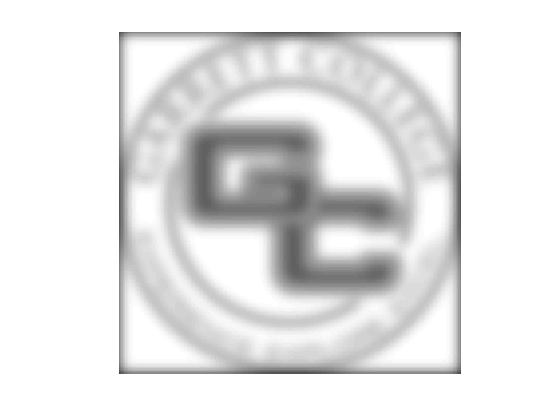

In [3]:
K = gblur(size(X,1), 5);     # A Gaussian blur kernel matrix
B = K * X * K';                         # Apply the blur...
imshow(B);                              # Let's look at it!

Wow, this is badly blurred. You can't even read it!

The `gblur` function takes two inputs:

1. The size of the image (assumed to be square--that is, equal number of rows and columns)
2. How slowly the blur dissipates away from the center out to the radius

**Experiment with the second to see the effect. Smaller numbers result in less blur.**

## OK, so what?

An actual application goes something like this. Imagine you've got a ground-based telescope looking up in the sky for sattelites. Instead of a satellite we spot the Garrett College logo up there, but it's blurry because of the atmosphere. In other words, we never saw the original, sharp image, but can only measure the blurry distorted image.

Fortunately, we can accurately estimate this atmospheric blur by shooting a laser either up or down through the atmosphere to a nearby control satellite, thus measuring the blur directly. We want to use this knowledge of the blur to recover the original, sharp image as best we can.

The conceptually simplest approach is to just solve the linear system of equations for the unknown, sharp image $x$, that is, solve

$$Ax=b$$

for $x$. A numerically bad approach to do this is to just conceptually divide each side by the matrix $A$, that is invert it. **Inverting matrices a bad idea in general for many reasons**, but in this problem there are even more severe numerical issues at hand. No matter how carefully we try to recover the original image using all the data, our answer will look very bad. Let's see:

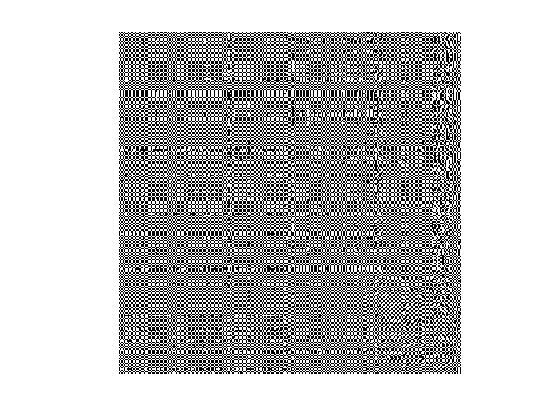

In [4]:
Kinv = inv(K);         # The inverted "un-blur" operator  ... very sketchy, note the warning
Y = Kinv * B * Kinv';  # Apply it to the blurry image, basically solve Ay=b for y.
imshow(Y);

Wow, that's some abstract-modern-art-level bad right there.

## What can be done?

Well, alot! One fundamental problem here is that some key values of the blurring kernel operator matrix $K$ are tiny--like, nearly zero tiny, so when we divide by them it's like multiplying by a gigantic number that blows everything up.

A great approach to dealing with this problem is to just ignore those tiny values somehow. An effective way to do that is to *project* the matrix into a lower-dimensional space that avoids the tiny values. We will talk about the details in class. The following cryptic code does that for you, so let's experiment...

This next step can be slow to run using the free hosting service we're using. It sets up the machinery that allows us to project the matrix into a lower-dimensional space that avoids thos problematic tiny values...

In [7]:
[U,S,V]=svd(K);

Once we have that, you can experiment with the size of the dimension to use. It's defined below with in the variable $n$. Experiment with different values of $n$ to see how the resulting "un-blurred" image output changes. The number $n$ can vary between 1 up to at most the size of the image (256 in this example):

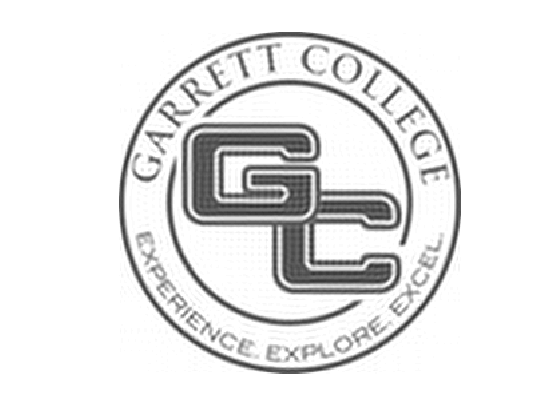

In [10]:
n = 100;      # Essentially, project down into a 100-dimensional space ... try different values here!
P = V(:, 1:n) * diag(1./diag(S(1:n,1:n))) * U(:, 1:n)';    # This is the projected inverse blur kernel matrix
Y = P * B * P';    # apply that to the blurry image B to try to restore it...
imshow(Y);

Not bad! This 100-dimension projection does pretty good.

Experiment with different values of N, different Gaussian blur parameters, whatever and show me a few results.

If you are adventureous, you can try a different image. Beware though that this system is really slow, so big images will take too long to compute.